In [13]:
from __future__ import annotations
from typing import Final as const, Any

In [14]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torch.utils.data import DataLoader

## CNNモデルの作成

### 1. アノテーション付き画像データのロード
ここではCOCO形式でエクスポートされたアノテーション付き画像データを教師データとして使用します。

In [15]:
#1.学習データ（COCO形式）のロード
from torchvision.datasets import CocoDetection
import torchvision.transforms as transforms

img_folder_path: str = "./TrainDataSet/"
anno_file_path: str = "./TrainDataSet/result.json"

#Transformsの定義
transform = transforms.Compose([
    transforms.ToTensor()
])

#COCOデータセットのロード
coco_dataset = CocoDetection(img_folder_path, anno_file_path, transform=transform)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


### 2.モデルの準備
今回は少ないデータセットで学習させるため、FRCNNの事前学習済みモデルをファインチューニングして学習させます。その際、CUDAが使用可能な場合はGPUを使って計算をするよう設定を行います。

In [16]:
#2.モデル準備
model = fasterrcnn_resnet50_fpn(pretrained=True)
data_loader: DataLoader = DataLoader(coco_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
#CUDAが使えるならGPUを使う
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == torch.device("cuda"):
    model.to(device)
    print(f"Using device: {device}")
else:
    print("Using CPU")


f:\syu\Products\OCR-Sample\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
f:\syu\Products\OCR-Sample\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cuda


### 3.ファインチューニングによるモデルの再学習

In [22]:
#3.ファインチューニング
model.train()
for images, targets in data_loader:
    images = list(image.to(device) for image in images)
    targets = [{k: (v.to(device) if torch.is_tensor(v) else v) for k, v in t.items()} for target_list in targets for t in target_list]


### 4.モデルの保存

In [24]:
import os

save_path = "./Models/Model_F-RCNN-0.1.pth"
if os.path.exists(save_path) is False:
    os.makedirs(os.path.dirname(save_path))


torch.save(model.state_dict(), save_path)

## CNN利用した紙面検知の検証

In [48]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

### 1.保存したモデルの読み込みと推論モードへの切り替え

In [33]:
#保存したモデルの読み込み
model_path: const[str] = "./Models/Model_F-RCNN-0.1.pth"
model = fasterrcnn_resnet50_fpn(pretrained=False) #Fast-RCNNを指定
model.load_state_dict(torch.load(model_path))
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == torch.device("cuda"):
    model.to(device)
    print(f"Using device: {device}")
else:
    print("Using CPU")
"""
#model.to(device) #GPUにモデルを転送
#学習モードから評価モードへの切り替え
model.eval()

f:\syu\Products\OCR-Sample\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
f:\syu\Products\OCR-Sample\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

### 2.モデルを使って入力画像から紙面を特定する

In [55]:
def prediction(img_path: str, plot_title: str="") -> None:
    #入力画像の指定
    img = Image.open(img_path)

    #Tensorに変換
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    img_tensor = transform(img).unsqueeze(0)

    #推論
    with torch.no_grad():
        pred = model(img_tensor)

    #推論結果の描画
    #スコアが最大のものを抽出
    image_np = img_tensor[0].numpy().transpose((1, 2, 0))
    #image_np_rotated = np.rot90(image_np, -1)  # 90度回転
    fig, ax = plt.subplots(1, figsize=(10, 20))
    ax.imshow(image_np)

    # スコアが最大のバウンディングボックスと信頼度の描画
    max_score_idx = pred[0]['scores'].numpy().argmax()
    box = pred[0]['boxes'].numpy()[max_score_idx]
    score = pred[0]['scores'].numpy()[max_score_idx]

    x, y, xmax, ymax = box
    rect = patches.Rectangle((x, y), xmax-x, ymax-y, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(x, y, f"{score:.2f}", color="white", bbox=dict(facecolor='red', alpha=0.5))
    ax.set_title(plot_title)

    plt.show()

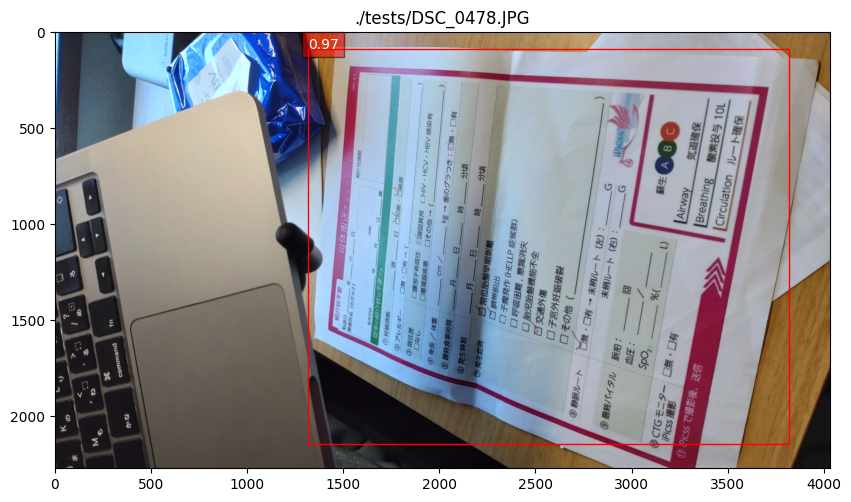

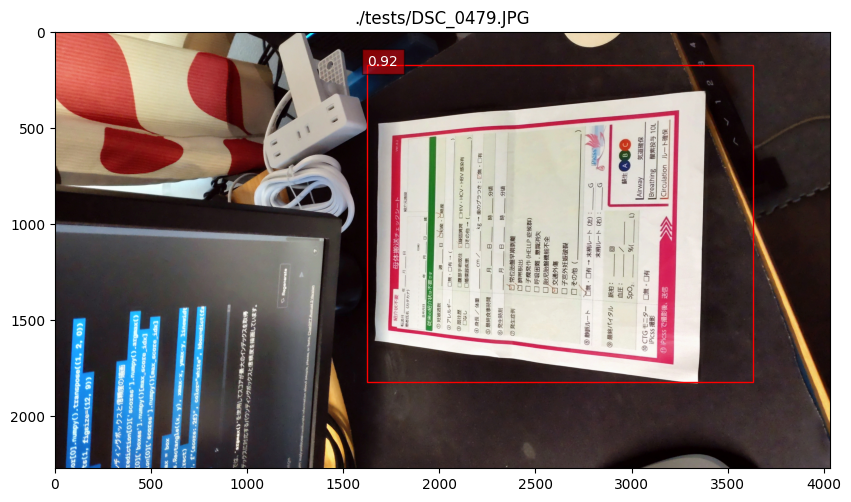

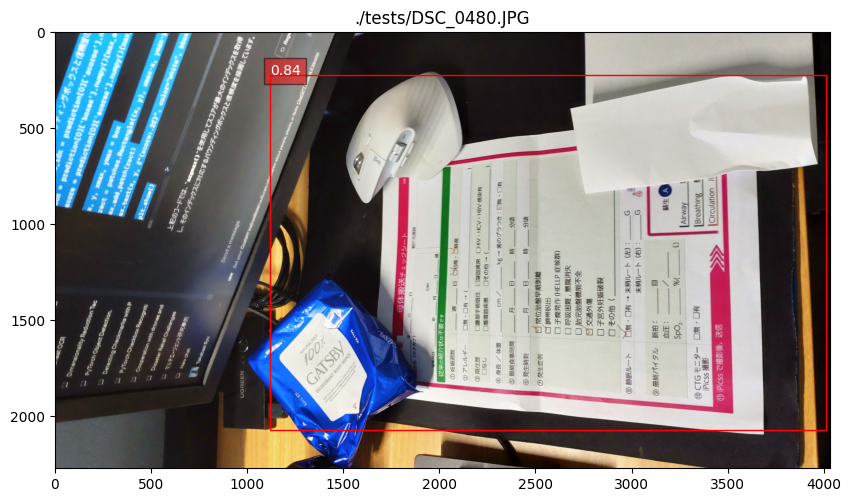

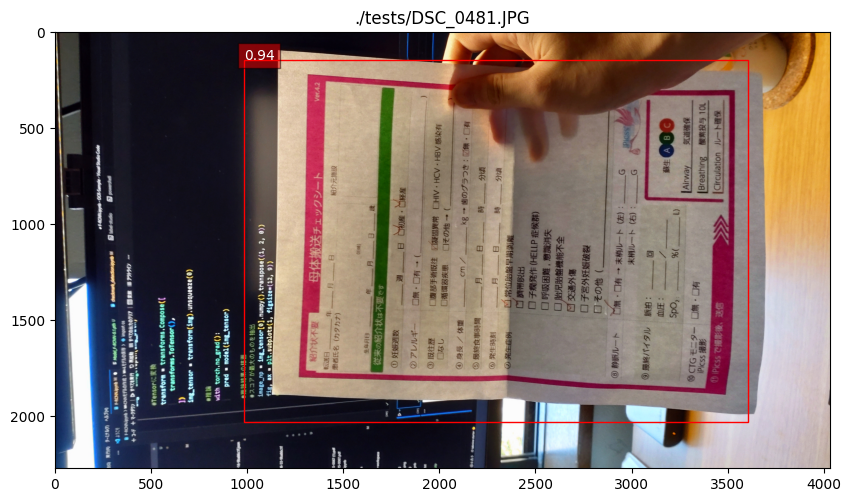

In [56]:
prediction("./tests/DSC_0478.JPG", "./tests/DSC_0478.JPG")
prediction("./tests/DSC_0479.JPG", "./tests/DSC_0479.JPG")
prediction("./tests/DSC_0480.JPG", "./tests/DSC_0480.JPG")
prediction("./tests/DSC_0481.JPG", "./tests/DSC_0481.JPG")
